In [1]:
# Test script for classification
# Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import numpy as np
import pandas as pd
import os
import sys
import importlib

# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
import initFunctions as initf #import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

importlib.reload(initf)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = initf.createDirs(rootDir, switchDir, dirDict)

c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\aboha\.conda\envs\cFosV1\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

feature count shifted from 315 to 301, removing all features with instance of 'cell_density' over 46263.64


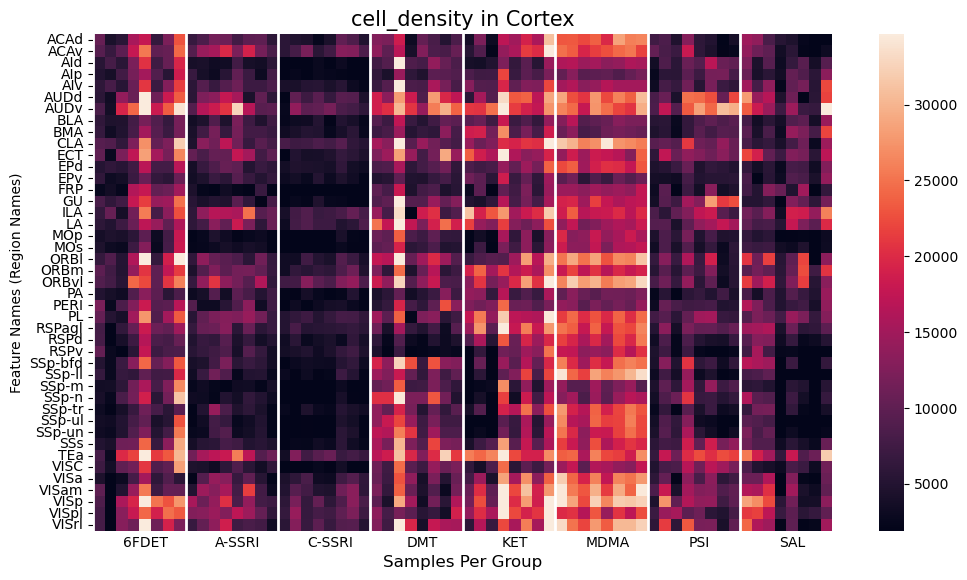

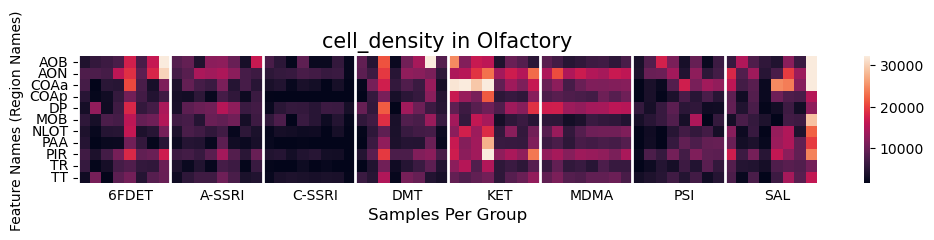

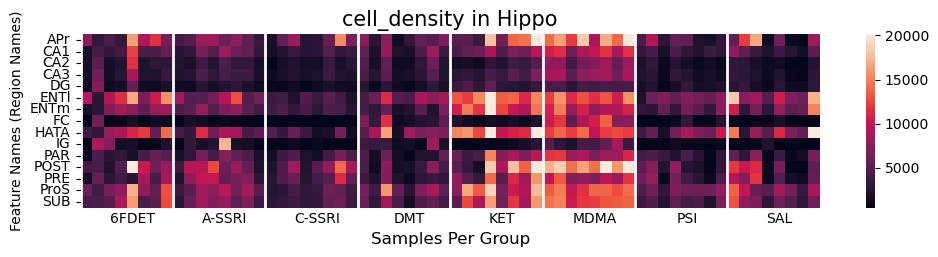

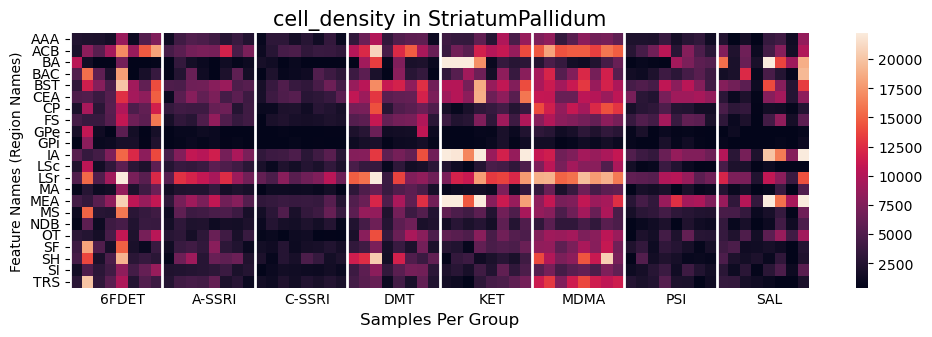

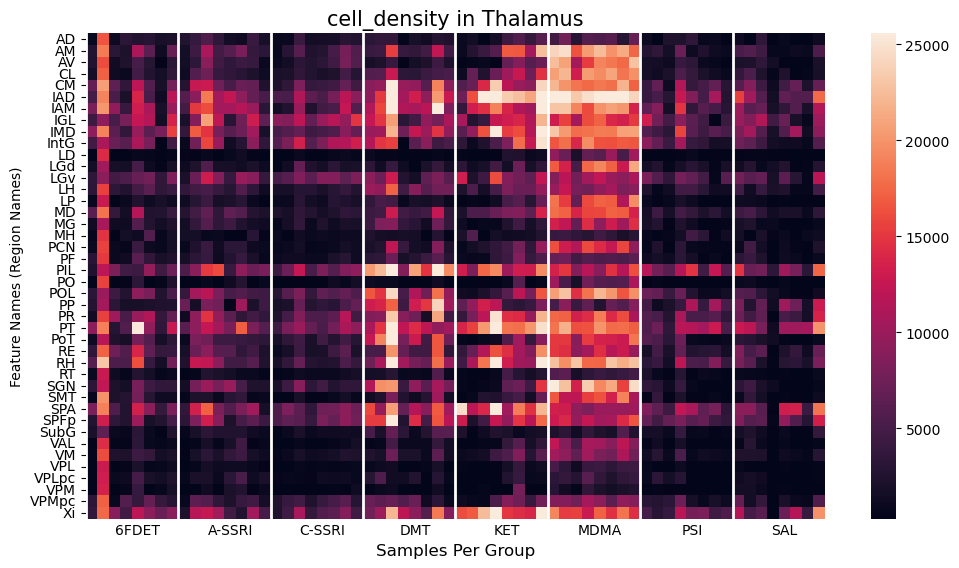

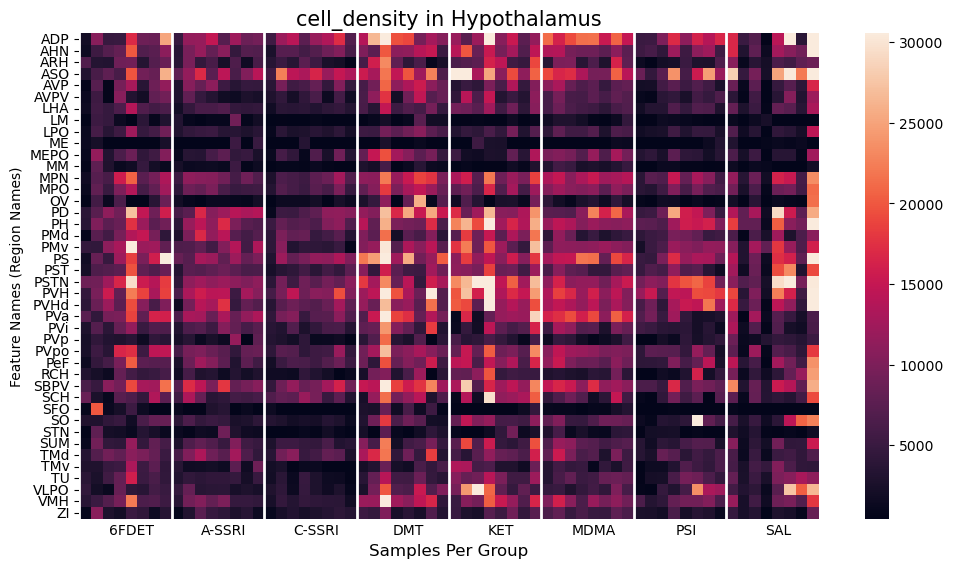

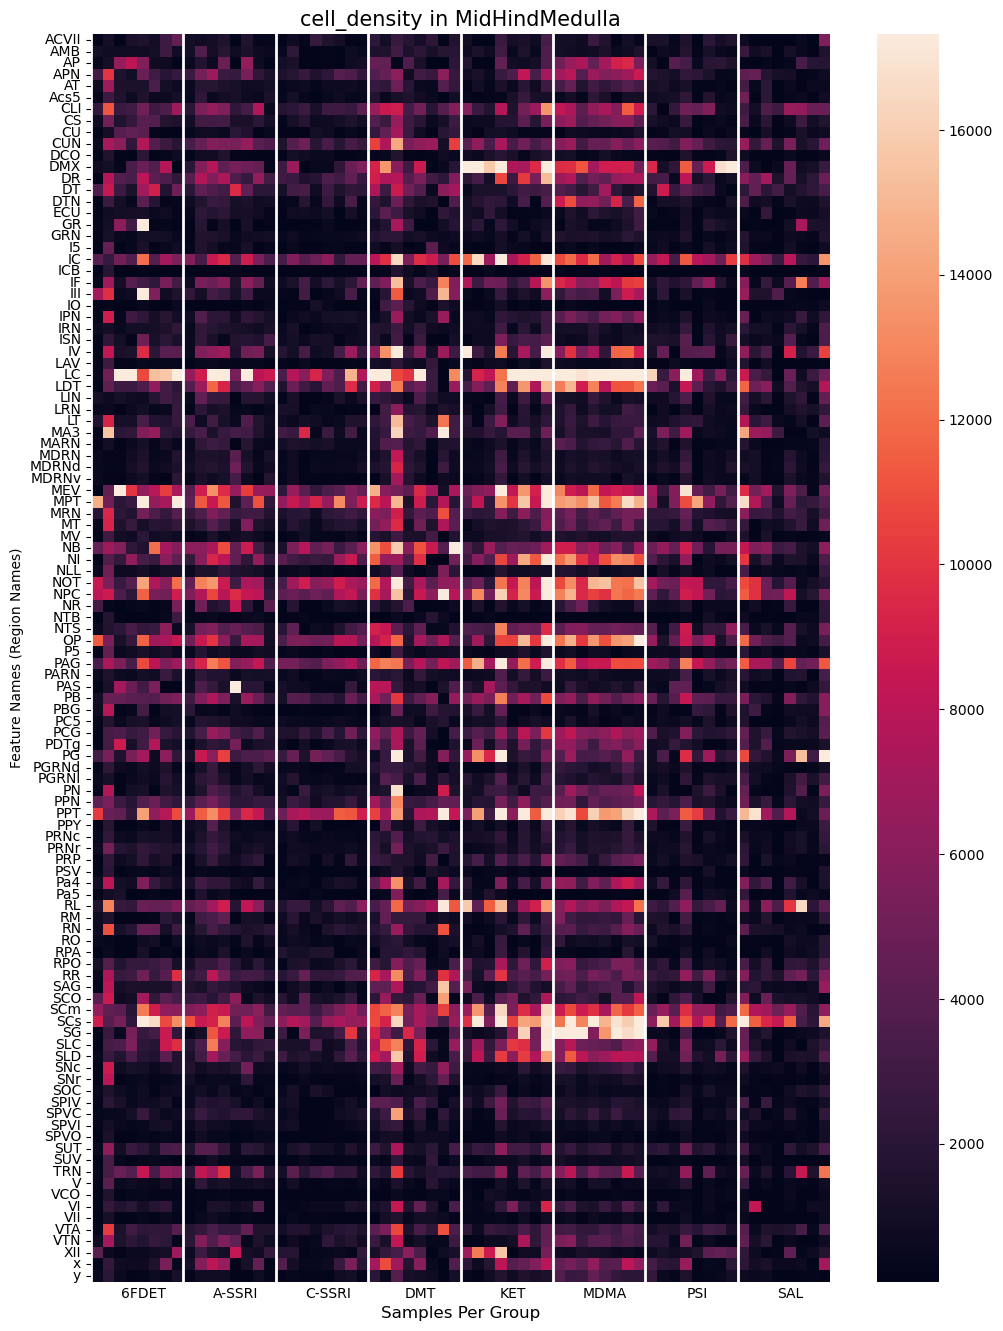

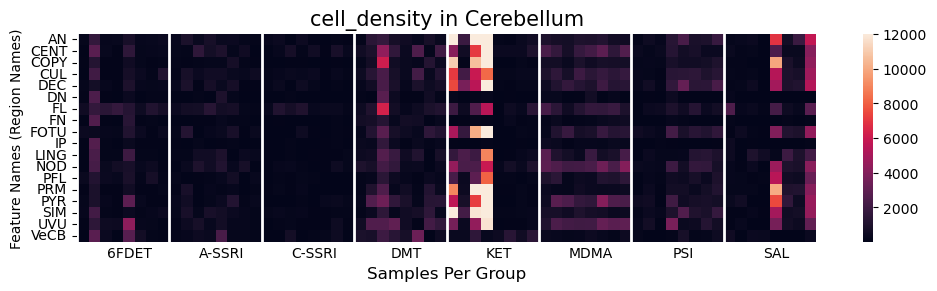

In [5]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'cell_density' #cell_density, count
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'class_5HT2A' #'drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = True
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for classification
classifyDict['model_featureScale'] = True # True, False
classifyDict['model_featureLogScale'] = False # True, False
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'

# Used for Fdr, Fwe, and Fwe_BH
classifyDict['model_featureSel_alpha'] = 0.05 

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'modelPer' # 'gridCV', 'modelPer'
# classifyDict['model_featureSel_k'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
classifyDict['model_featureSel_k'] = [30]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'ElasticNet', 'LDA', 'RandomForest'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]          # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                    # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = False
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8 

if classifyDict['label'] == 'drug':
    classifyDict['test_size'] = 1/8
    classifyDict['innerFold'] = 7
else:
    classifyDict['test_size'] = 1/4
    classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True
dirDict['uniqID'] = 'try100'

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl')

# Big Data - the dataset prior to filtering based on summary structures
# lightsheet_data = pd.read_pickle('lightsheet_data_big.pkl')
# lightsheet_data.rename(columns={'Brain Area': 'Brain_Area'}, inplace=True)

# Pure visualizations
lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)
plotFunctions.data_heatmap(lightsheet_data_filt, classifyDict, dirDict)
# plotFunctions.data_heatmap_single(lightsheet_data, classifyDict, dirDict)

# Statistics
# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)

# classifyDict['dimRed'] = 'SVC'
# plotFunctions.dim_red_plot(lightsheet_data_filt, classifyDict, dirDict)

# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

# valRange = np.arange(1,9)
# grids = np.meshgrid(valRange, valRange, valRange, valRange, valRange, valRange, valRange, valRange)
# combinations = np.column_stack([grid.flatten() for grid in grids])
# classifyFunctions.bootstrap_fstat(lightsheet_data, classifyDict, dirDict)

# classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

Classifying class_KetPsi
Loading filtered and aggregated data from file...density-KetPsi-featFilt-nofeatAgg
evaluating model: BorutaFeatureSelector() -> RobustScaler() -> LogisticRegression(multi_class='multinomial', solver='saga')
Performing CV split 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

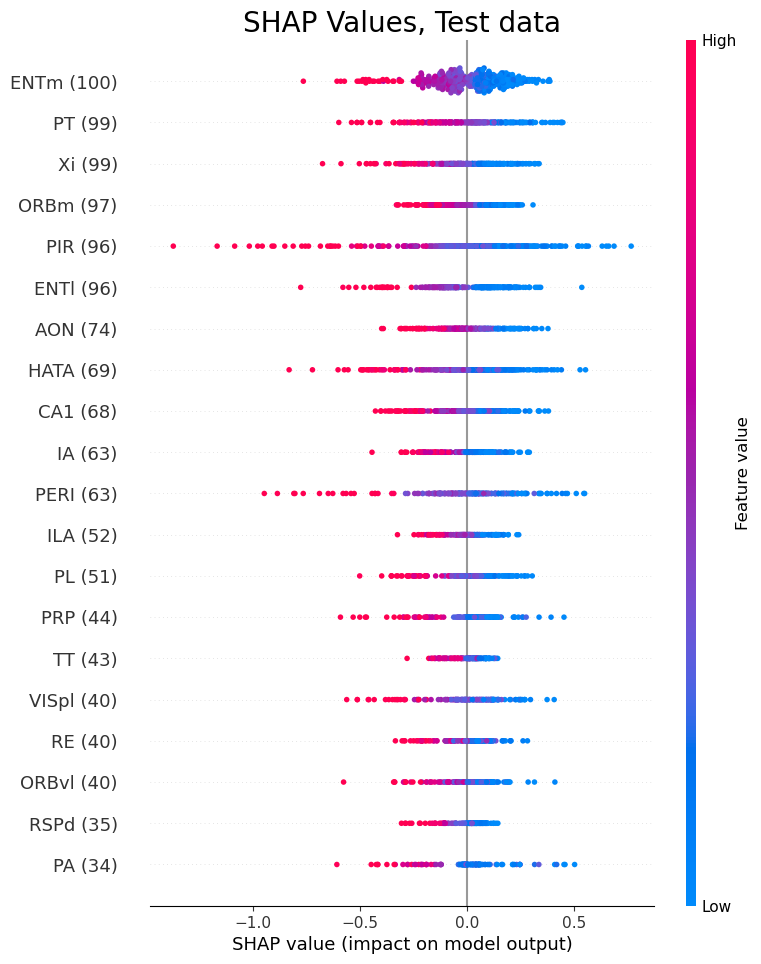

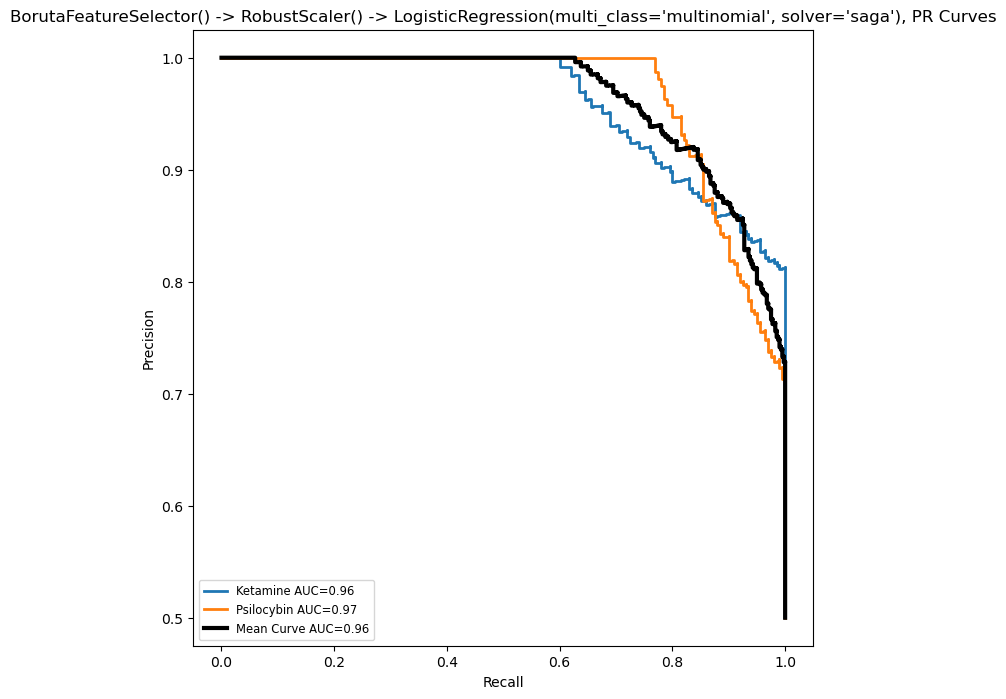

Real: 0.88 accuracy with a standard deviation of 0.13


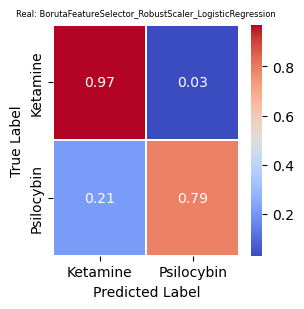

==== Ketamine vs Psilocybin ==== 
 Features per Model: [22, 21, 21, 21, 23, 17, 19, 43, 19, 19, 21, 35, 22, 18, 13, 20, 18, 19, 24, 13, 15, 20, 18, 15, 15, 16, 16, 17, 23, 26, 19, 20, 24, 21, 20, 20, 18, 27, 21, 17, 23, 18, 19, 26, 20, 17, 21, 22, 22, 18, 21, 20, 24, 16, 23, 20, 16, 39, 21, 17, 19, 21, 17, 24, 17, 14, 24, 17, 22, 20, 32, 21, 20, 18, 22, 21, 14, 22, 19, 18, 10, 21, 17, 18, 20, 16, 28, 18, 18, 28, 23, 24, 18, 33, 22, 21, 18, 29, 17, 17]
Parameters: 
 
Total Regions = 104 
 Present 1x: 14 - ACAd, SSp-tr, VISa, VISal, IGL, SAG, LSv, MEA, PAG, PVp, PC5, PCN, AMB, PRNc
Present 2x: 12 - NPC, DCO, SG, TMd, PSTN, VeCB, PPY, IF, AIv, TRN, AM, PIL
Present 3x: 8 - TR, SUV, OV, MV, NDB, VMPO, RPO, CLA
Present 4x: 5 - SO, LH, SCH, SLD, SPFp
Present 5x: 7 - B, SBPV, CL, VISam, PVpo, PCG, SLC
Present 6x: 6 - PeF, IAM, IMD, RH, SUT, PR
Present 7x: 2 - PST, IPN
Present 8x: 3 - CM, BMA, LHA
Present 10x: 3 - COAp, CA3, RL
Present 11x: 2 - AAA, PH
Present 14x: 1 - NI
Present 15x: 1 - ARH
P

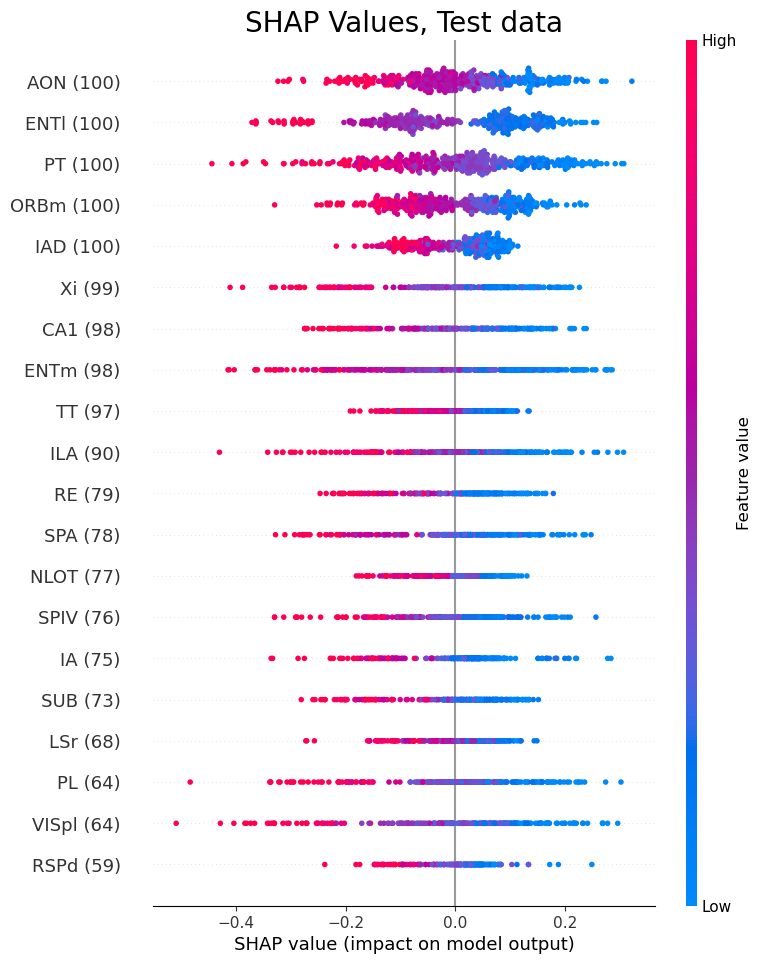

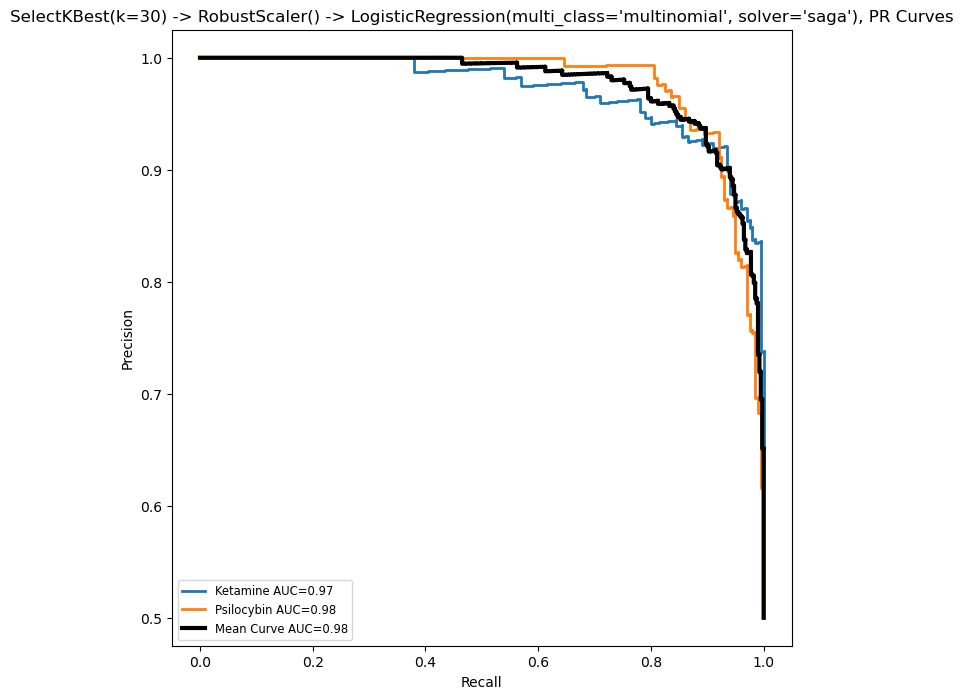

Real: 0.92 accuracy with a standard deviation of 0.15


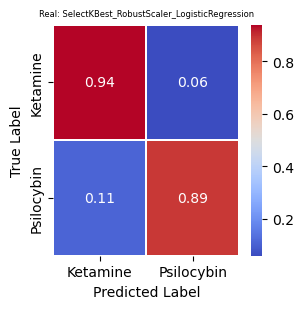

==== Ketamine vs Psilocybin ==== 
 Features per Model: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Parameters: 
 
Total Regions = 121 
 Present 1x: 23 - LDT, PCG, ACB, AM, VeCB, FN, RH, B, AOB, IF, VMPO, DTN, LM, SCH, RSPv, VISa, I5, PCN, VMH, LSc, PRE, SubG, FC
Present 2x: 7 - x, MRN, DMX, PST, CLA, POST, VISl
Present 3x: 9 - SH, AHN, ICB, SLC, CM, PRNc, PSTN, SBPV, ACAd
Present 4x: 4 - PIL, DCO, AAA, VISpm
Present 5x: 4 - SSp-tr, ZI, TRN, BAC
Present 6x: 4 - IPN, SUV, VCO, TR
Present 7x: 4 - ECT, AIv, IAM, LSv
Present 8x: 3 - SF, LH, PVp
Present 9x: 4 - PDTg, EPv, PN, TU
Present 10x: 3 - PSV, NI, RCH
Present 11x: 3 - VISam, PMd, MEA


In [3]:
# classifyVec = ['drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI']
classifyVec = ['class_KetPsi']
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except:
      print(f"\n Failed to classify {i}")

# Rerun everything with 30 best features, as determined by univariate feature selection
classifyDict['model_featureSel'] = 'Univar' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_k'] = [30]

for i in classifyVec:
    try:
        print(f"Classifying {i} with Univar")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except:
      print(f"\n Failed to classify {i}")